In [393]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import debug


In [394]:
# Configure image
image = cv2.imread("../images/boards/red_white_angled.jpeg")
image_size = (700,700)
image = cv2.resize(image,image_size)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, threshold1=1150, threshold2=200) 

Detect chessboard borders

In [395]:
lines = cv2.HoughLines(canny,rho = 1, theta = np.pi / 180, threshold = 200)
lines = lines.reshape(len(lines),2)
lines = lines[lines[:, 0].argsort()]

HIGH_VALUE = 500
while(len(lines) > 4):
    
    less_diff = HIGH_VALUE
    
    for i in range(len(lines)-1):
        
        difference = lines[i + 1][0] - lines[i][0]
        if  difference < less_diff:
            less_diff = difference
            duplicate = i
            
    lines = np.delete(lines, duplicate, axis=0)

def polar_to_coor(lines):
    
    coor_lines = []
    for line in lines:
        rho,theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1000 *(-b))
        y1 = int(y0 +1000*(a))
        x2 = int(x0 -1000*(-b))
        y2 = int(y0 -1000*(a))   
        coor_lines.append(((x1,y1),(x2,y2)))
    
    return coor_lines
    
lines = polar_to_coor(lines)  

#debug.lines(image, lines, size = 7)


Detect chesboard corners

In [396]:
def line_intersection(lines):

    points =[]
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):

            line1 = lines[i]
            line2 = lines[j]
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div != 0:
                

                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div
                points.append((x,y)) 
    return points

intersections = line_intersection(lines)

#debug.points(image,inter,color = (0,255,0),size = 10)
inters = np.array(intersections)
inters = inters[np.all((-100 <= inters) & (inters <= 800), axis=1)] # Delete point outside -100 and 800
sorted_intersections = inters[inters[:, 0].argsort()]

sorted_intersections

array([[ 30.41947039, 548.13372613],
       [165.24506286,  43.58291399],
       [556.40087604,  43.77858973],
       [707.08962013, 536.28607469]])

Trim image

In [397]:
vertex = np.array(sorted_intersections, np.int32)
black_mask = np.zeros_like(image)
cv2.fillPoly(black_mask, [vertex], (255, 255, 255))
trimmed_image = cv2.bitwise_and(image, black_mask)

Detect inner corners

In [398]:
gray_trimmed_image = cv2.cvtColor(trimmed_image, cv2.COLOR_BGR2GRAY)
max_corners = 80
corners = cv2.goodFeaturesToTrack(gray_trimmed_image, max_corners, qualityLevel= 0.1, minDistance= 15)
corners = np.intp(corners)
actual_size = corners.shape[0], corners.shape[2]
corners = corners.reshape(actual_size)

debug.points(trimmed_image,corners, color=(0,255,0), size= 5);

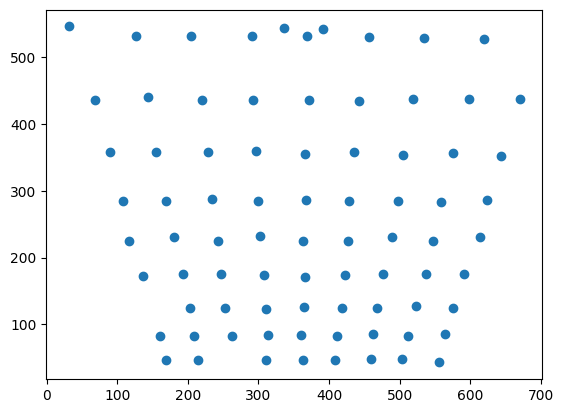

In [399]:
plt.scatter(corners[:,0], corners[:,1])

In [400]:
cv2.imshow('Imagen Original', image)
#cv2.imshow('canny', canny)
cv2.imshow('Imagen Recortada', trimmed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()